In [2]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.applications import VGG16
import tensorflow as tf

## **Data Preprocessing**

In [3]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

# Parse numbers as floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize data
X_train = (X_train) / 255.
X_test = (X_test) / 255.

# number of classes
nb_classes = len(np.unique(y_train))

img_width, img_height, img_num_channels = 32, 32, 3
input_shape = (img_width, img_height, img_num_channels)

y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

## **Different learning rates**

In [ ]:
lr_schedule = [
    0.001,  
    0.0005, 
    0.0001, 
    0.0001, 
    0.00005
]

optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[10000, 20000, 30000], 
        values=lr_schedule
    )
)

## **Define model with at least 5 layers**

In [20]:
model = Sequential()
model.add(Conv2D(128, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('elu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('elu'))

model.add(Conv2D(256, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 activation_8 (Activation)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       147584    
                                                                 
 activation_9 (Activation)   (None, 30, 30, 128)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 15, 15, 256)       295168    
                                                      

## **Compile Model**

In [21]:
model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate = 0.0001), metrics=['accuracy'])

## **Data augmentation**

In [22]:
data = ImageDataGenerator(
            featurewise_center=False,  
            samplewise_center=False,  
            featurewise_std_normalization=False,  
            samplewise_std_normalization=False,  
            zca_whitening=False,  
            rotation_range=0,  
            width_shift_range=0.1,  
            height_shift_range=0.1,  
            horizontal_flip=True, 
            vertical_flip=False)  
data.fit(X_train)


## **Fit data to mode**

In [23]:
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights = True)

history = model.fit(data.flow(X_train, y_train, batch_size=50), 
                   steps_per_epoch=X_train.shape[0] // 50,
                   epochs=50,
                   validation_data=(X_test, y_test),
                   verbose=1,
                   callbacks=[stop])

Epoch 1/50
1000/1000 [==============================] - 44s 42ms/step - loss: 3.9194 - accuracy: 0.1061 - val_loss: 3.3201 - val_accuracy: 0.2104
Epoch 2/50
1000/1000 [==============================] - 40s 40ms/step - loss: 3.3173 - accuracy: 0.2061 - val_loss: 2.8467 - val_accuracy: 0.3104
Epoch 3/50
1000/1000 [==============================] - 41s 41ms/step - loss: 3.0254 - accuracy: 0.2608 - val_loss: 2.6282 - val_accuracy: 0.3479
Epoch 4/50
1000/1000 [==============================] - 40s 40ms/step - loss: 2.8357 - accuracy: 0.2999 - val_loss: 2.5290 - val_accuracy: 0.3708
Epoch 5/50
1000/1000 [==============================] - 40s 40ms/step - loss: 2.7007 - accuracy: 0.3276 - val_loss: 2.4619 - val_accuracy: 0.3833
Epoch 6/50
1000/1000 [==============================] - 40s 40ms/step - loss: 2.5845 - accuracy: 0.3500 - val_loss: 2.2506 - val_accuracy: 0.4275
Epoch 7/50
1000/1000 [==============================] - 41s 41ms/step - loss: 2.4864 - accuracy: 0.3703 - val_loss: 2.1705 -

## **Plot history**

Test loss: 1.3731027841567993 / Test accuracy: 0.6237999796867371


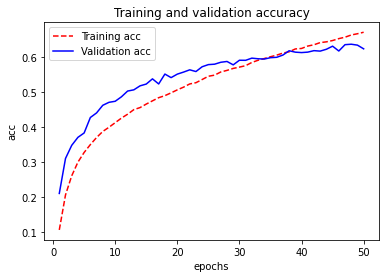

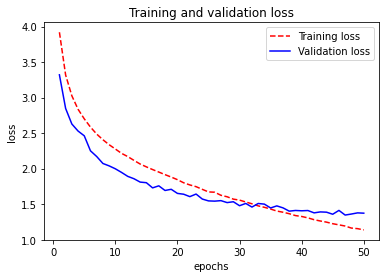

<Figure size 432x288 with 0 Axes>

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')


def plot_history(history):
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1,len(acc)+1,1)

    plt.plot(epochs,acc, 'r--', label='Training acc')
    plt.plot(epochs,val_acc,  'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

    plt.plot( epochs,loss,'r--', label='Training loss')
    plt.plot(epochs, val_loss ,  'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()

plot_history(history)


## **Define VGG16**

In [4]:
base_model = VGG16(include_top=False,input_shape=(32,32,3),classes=100)

In [5]:
vggmodel = tf.keras.models.Sequential()
vggmodel.add(base_model)
vggmodel.add(tf.keras.layers.Flatten())
vggmodel.add(tf.keras.layers.Dense(1024, activation='relu'))
vggmodel.add(tf.keras.layers.Dropout(0.2))
vggmodel.add(tf.keras.layers.Dense(100, activation='softmax'))

In [6]:
vggmodel.compile(loss=categorical_crossentropy, metrics=['accuracy'])

In [15]:
stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=8, restore_best_weights = True)

vgghistory = vggmodel.fit(data.flow(X_train, y_train, batch_size=50), 
                   steps_per_epoch=X_train.shape[0] // 50,
                   epochs=10,
                   validation_data=(X_test, y_test),
                   verbose=1,
                   callbacks=[stop])

Epoch 1/10
1000/1000 [==============================] - 44s 44ms/step - loss: 3.8406 - accuracy: 0.1172 - val_loss: 3.2573 - val_accuracy: 0.2255
Epoch 2/10
1000/1000 [==============================] - 41s 40ms/step - loss: 3.2678 - accuracy: 0.2150 - val_loss: 2.8485 - val_accuracy: 0.3028
Epoch 3/10
1000/1000 [==============================] - 40s 40ms/step - loss: 2.9892 - accuracy: 0.2711 - val_loss: 2.6463 - val_accuracy: 0.3450
Epoch 4/10
1000/1000 [==============================] - 40s 40ms/step - loss: 2.8171 - accuracy: 0.3027 - val_loss: 2.4472 - val_accuracy: 0.3855
Epoch 5/10
1000/1000 [==============================] - 40s 40ms/step - loss: 2.6768 - accuracy: 0.3303 - val_loss: 2.3350 - val_accuracy: 0.4048
Epoch 6/10
1000/1000 [==============================] - 41s 41ms/step - loss: 2.5740 - accuracy: 0.3520 - val_loss: 2.3001 - val_accuracy: 0.4130
Epoch 7/10
1000/1000 [==============================] - 41s 41ms/step - loss: 2.4746 - accuracy: 0.3719 - val_loss: 2.1975 -

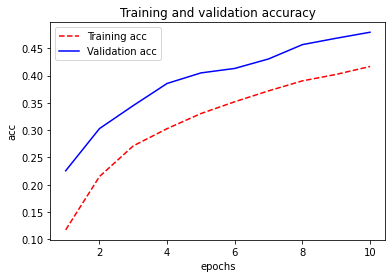

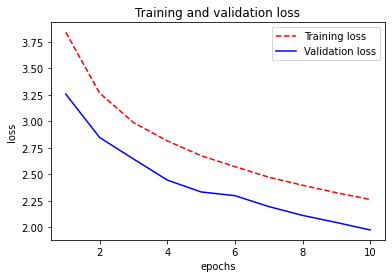

<Figure size 432x288 with 0 Axes>

In [19]:
plot_history(vgghistory)